In [3]:
%matplotlib inline
import obspy
import numpy as np
import math
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

import matplotlib

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter
from matplotlib import gridspec

import hvsrpy
import sigpropy

import pandas as pd

import datetime

In [1]:
def get_hvsr_from_local(stN, stE, stZ, windowlength):
    """
    time: a string in the form of 2019-07-06T03:19:00.000
    dtbf & dtaft: should be 3000 (sec)
    network: a string from IRIS, example is "CI" or "NN"
    station: seismic station from IRIS, example is "SLA"
    location: keep as "*"
    """
    
    traceN = stN[0]
    traceE = stE[0]
    traceZ = stZ[0]
        
    if len(stN)>1:
        for i in range (1, len(stN)):
            traceN = traceN.__add__(stN[i], method=1, interpolation_samples=-1, fill_value='latest', sanity_checks=True)
            traceE = traceE.__add__(stE[i], method=1, interpolation_samples=-1, fill_value='latest', sanity_checks=True)
            traceZ = traceZ.__add__(stZ[i], method=1, interpolation_samples=-1, fill_value='latest', sanity_checks=True)
  
    starttime = traceN.stats.starttime
    min_end_time = np.array([traceN.stats.endtime, traceE.stats.endtime, traceZ.stats.endtime]).min()
    
    # datetime.timedelta from datetime module convert to time series 
    traceN = traceN.trim(starttime, min_end_time).slice(starttime=traceN.stats.starttime + datetime.timedelta(minutes=10), endtime=traceN.stats.endtime - datetime.timedelta(minutes=100))
    traceE = traceE.trim(starttime, min_end_time).slice(starttime=traceE.stats.starttime + datetime.timedelta(minutes=10), endtime=traceE.stats.endtime - datetime.timedelta(minutes=100))
    traceZ = traceZ.trim(starttime, min_end_time).slice(starttime=traceZ.stats.starttime + datetime.timedelta(minutes=10), endtime=traceZ.stats.endtime - datetime.timedelta(minutes=100))

    ns = sigpropy.TimeSeries(traceN.data, traceN.stats.delta)
    ew = sigpropy.TimeSeries(traceE.data, traceE.stats.delta)
    vt = sigpropy.TimeSeries(traceZ.data, traceZ.stats.delta)
    sensor = hvsrpy.Sensor3c(ns,ew,vt)
        
       # Window length in seconds. In general low frequency peaks require longer window lengths.
        # See the SESAME guidelines for specific window length recommendations.
        #windowlength = "windowlength" #changed from 60
        # Boolean to control whether Butterworth filter is applied. 
        # Geopsy does not apply a bandpass filter.
    # filter_bool = False
    filter_bool = True        
        # Low-cut frequency for bandpass filter.
    filter_flow = 0.1                   
        # High-cut frequency for bandpass filter.
    filter_fhigh = 50                   
        # Filter order.
    filter_order = 5
        # Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
    width = 0.1
        # Konno and Ohmachi smoothing constant. 40 is recommended.
    bandwidth = 30 #changed from 40
        # Minimum frequency after resampling
    resample_fmin = 0.3  
        # Maximum frequency after resampling
    resample_fmax = 20
        # Number of frequencies after resampling
    resample_fnum = 200
        # Type of resampling {'log', 'linear'}
    resample_type = 'log'
        # Upper and lower frequency limits to restrict peak selection. To use the entire range use `None`.
    peak_f_lower = None
    peak_f_upper = None
        # Method for combining horizontal components {"squared-average", "geometric-mean", "single-azimuth"}.
        # Geopsy's default is "squared-average" -> "geometric-mean" is recommended.
    method = "geometric-mean"
        # If method="single-azimuth", set azimuth in degree clock-wise from north. If method!="single-azimuth", value is ignored.
    azimuth = 0
        # Boolean to control whether frequency domain rejection proposed by Cox et al. (2020) is applied.
        # Geopsy does not offer this functionality.
    rejection_bool = True
        # Number of standard deviations to consider during rejection. Smaller values will reject more windows -> 2 is recommended.
    n = 2
        # Maximum number of iterations to perform for rejection -> 50 is recommended.
    max_iterations = 50
        # Distribution of f0 {"lognormal", "normal"}. Geopsy default "normal" -> "lognormal" is recommended.
    distribution_f0 = "lognormal"
        # Distribution of mean curve {"lognormal", "normal"}. Geopsy default "lognormal" -> "lognormal" is recommended.
    distribution_mc = "lognormal"
        # Manually set the ylimits of the HVSR figures. Default is None so limits will be set automatically.
    ymin, ymax = 0, 10
    bp_filter = {"flag":filter_bool, "flow":filter_flow, "fhigh":filter_fhigh, "order":filter_order}
    resampling = {"minf":resample_fmin, "maxf":resample_fmax, "nf":resample_fnum, "res_type":resample_type}
    
    hv = sensor.hv(windowlength, bp_filter, width, bandwidth, resampling, method, f_low=peak_f_lower, f_high=peak_f_upper, azimuth=azimuth)
    fig = plt.figure(figsize=(6,6), dpi=150)
    gs = fig.add_gridspec(nrows=6,ncols=6)

    ax0 = fig.add_subplot(gs[0:2, 0:3])
    ax1 = fig.add_subplot(gs[2:4, 0:3])
    ax2 = fig.add_subplot(gs[4:6, 0:3])

    if rejection_bool:
        ax3 = fig.add_subplot(gs[0:3, 3:6])
        ax4 = fig.add_subplot(gs[3:6, 3:6])
    else:
        ax3 = fig.add_subplot(gs[0:3, 3:6])
        ax4 = False


    individual_width = 0.3
    median_width = 1.3
    for ax, title in zip([ax3, ax4], ["Before Rejection", "After Rejection"]):
                # Rejected Windows
        if title=="After Rejection":
            if len(hv.rejected_window_indices):
                label = "Rejected"
                for amp in hv.amp[hv.rejected_window_indices]:
                    ax.plot(hv.frq, amp, color='#00ffff', linewidth=individual_width, zorder=2, label=label)
                    label=None

                # Accepted Windows
        label="Accepted"
        for amp in hv.amp[hv.valid_window_indices]:
            ax.plot(hv.frq, amp, color='#888888', linewidth=individual_width,
                    label = label if title=="Before Rejection" else "")
            label=None

                # Window Peaks
        ax.plot(hv.peak_frq, hv.peak_amp, linestyle="", zorder=2,
                marker='o', markersize=2.5, markerfacecolor="#ffffff", markeredgewidth=0.5, markeredgecolor='k',
                label="" if title=="Before Rejection" and rejection_bool else r"$f_{0,i}$")

                # Peak Mean Curve
        ax.plot(hv.mc_peak_frq(distribution_mc), hv.mc_peak_amp(distribution_mc), linestyle="", zorder=4,
                marker='D', markersize=4, markerfacecolor='#66ff33', markeredgewidth=1, markeredgecolor='k', 
                label = "" if title=="Before Rejection" and rejection_bool else r"$f_{0,mc}$")

             # Mean Curve
        label = r"$LM_{curve}$" if distribution_mc=="lognormal" else "Mean"   
        ax.plot(hv.frq, hv.mean_curve(distribution_mc), color='k', linewidth=median_width,
                label="" if title=="Before Rejection" and rejection_bool else label)

            # Mean +/- Curve
        label = r"$LM_{curve}$"+" ± 1 STD" if distribution_mc=="lognormal" else "Mean ± 1 STD"
        ax.plot(hv.frq, hv.nstd_curve(-1, distribution_mc),
                color='k', linestyle='--', linewidth=median_width, zorder=3,
                label = "" if title=="Before Rejection" and rejection_bool else label)
        ax.plot(hv.frq, hv.nstd_curve(+1, distribution_mc),
                color='k', linestyle='--', linewidth=median_width, zorder=3)

            # f0 +/- STD
        if ymin is not None and ymax is not None:
            ax.set_ylim((ymin, ymax))
        label = r"$LM_{f0}$"+" ± 1 STD" if distribution_f0=="lognormal" else "Mean f0 ± 1 STD"    
        _ymin, _ymax = ax.get_ylim()
        ax.plot([hv.mean_f0_frq(distribution_f0)]*2, [_ymin, _ymax], linestyle="-.", color="#000000")
        ax.fill([hv.nstd_f0_frq(-1, distribution_f0)]*2 + [hv.nstd_f0_frq(+1, distribution_f0)]*2, [_ymin, _ymax, _ymax, _ymin], 
                color = "#ff8080",
                label="" if title=="Before Rejection" and rejection_bool else label)
        ax.set_ylim((_ymin, _ymax))

        ax.set_xscale('log')
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("HVSR Amplitude")
        if rejection_bool:
            if title=="Before Rejection":
                print("\nStatistics before rejection:")
                hv.print_stats(distribution_f0)
                c_iter = hv.reject_windows(n, max_iterations=max_iterations, 
                                            distribution_f0=distribution_f0, distribution_mc=distribution_mc)
            elif title=="After Rejection":
                fig.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.51, 0), columnspacing=2)

                print("\nAnalysis summary:")  
                display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows", "Number of iterations to convergence", "No. of rejected windows"], 
                        data=[f"{windowlength}s", str(sensor.ns.nseries), f"{c_iter} of {max_iterations} allowed", str(sum(hv.rejected_window_indices))]))            
                print("\nStatistics after rejection:")
                hv.print_stats(distribution_f0)
        else:
            display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows"], 
                                data=[f"{windowlength}s", str(sensor.ns.nseries)]))
            hv.print_stats(distribution_f0)
            fig.legend(loc="upper center", bbox_to_anchor=(0.77, 0.4))
            break
        ax.set_title(title)

    norm_factor = sensor.normalization_factor
    for ax, timerecord, name in zip([ax0,ax1,ax2], [sensor.ns, sensor.ew, sensor.vt], ["NS", "EW", "VT"]):
        ctime = timerecord.time
        amp = timerecord.amp/norm_factor
        ax.plot(ctime.T, amp.T, linewidth=0.2, color='#888888')
        ax.set_title(f"Time Records ({name})")
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax.set_xlim(0, windowlength*timerecord.nseries)
        ax.set_ylim(-1, 1)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Normalized Amplitude')
        ax.plot(ctime[hv.rejected_window_indices].T, amp[hv.rejected_window_indices].T, linewidth=0.2, color="cyan")

    if rejection_bool:
        axs = [ax0, ax3, ax1, ax4, ax2]
    else:
        axs = [ax0, ax3, ax1, ax2]

    for ax, letter in zip(axs, list("abcde")):    
        ax.text(0.97, 0.97, f"({letter})", ha="right", va="top", transform=ax.transAxes, fontsize=12)
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)


    fig.tight_layout(h_pad=1, w_pad=2, rect=(0,0.08,1,1))
    plt.title(f"{traceN.stats.station}")
    plt.show()
    print()
            
            
    return hv.mc_peak_frq(), hv.mc_peak_amp()

In [3]:
stations = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
windowlengths = [200,200, 400, 400, 400, 400, 200, 200, 200, 200]
for i, station in enumerate(stations):
    stN = obspy.read(f"NX.USC{station}..HHN.D.2022.207")
    stE = obspy.read(f"NX.USC{station}..HHE.D.2022.207")
    stZ = obspy.read(f"NX.USC{station}..HHZ.D.2022.207")
    get_hvsr_from_local(stN, stE, stZ, windowlengths[i])


Statistics before rejection:


,Lognormal Median,Lognormal Standard Deviation
"Fundamental Site Frequency, f0",1.32,0.07
"Fundamental Site Period, T0",0.76,0.07



Analysis summary:


,
Window length,200s
No. of windows,57
Number of iterations to convergence,3 of 50 allowed
No. of rejected windows,3



Statistics after rejection:


,Lognormal Median,Lognormal Standard Deviation
"Fundamental Site Frequency, f0",1.33,0.06
"Fundamental Site Period, T0",0.75,0.06


KeyboardInterrupt: 

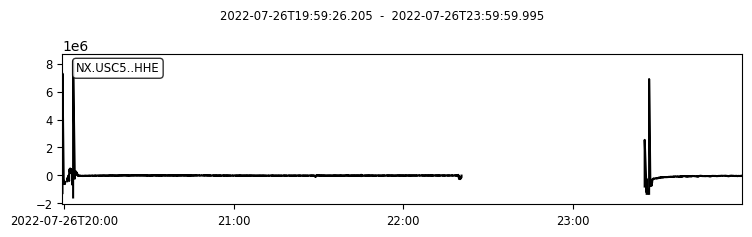

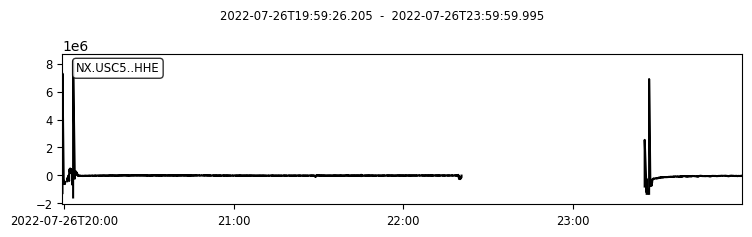

In [10]:
obspy.read('NX.USC5 ..HHE.D.2022.207').plot()